In [1]:
import os
import sys
# modules=['NiaEnv/2022a', 'python/3.9.10', 'gcc/11.3.0', 'fftw/3.3.10']
# for mod in modules:
#     os.system("module --ignore_cache load "+mod)
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
# from albatros_analysis.src.correlations import correlations as cr
import numba as nb
import time
from scipy import linalg
#from scio import scio
from scipy import stats

BDC is using numpy


In [2]:
T_SPECTRA = 4096/250e6

In [3]:
@nb.njit()
def get_common_rows(specnum0,specnum1,idxstart0,idxstart1):
    nrows0,nrows1=specnum0.shape[0],specnum1.shape[0]
    maxrows=min(nrows0,nrows1)
    rownums0=np.empty(maxrows,dtype='int64')
    rownums0[:]=-1
    rownums1=rownums0.copy()
    rowidx=rownums0.copy()
    i=0;j=0;row_count=0;
    while i<nrows0 and j<nrows1:
        if (specnum0[i]-idxstart0)==(specnum1[j]-idxstart1):
            rownums0[row_count]=i
            rownums1[row_count]=j
            rowidx[row_count]=specnum0[i]-idxstart0
            i+=1
            j+=1
            row_count+=1
        elif (specnum0[i]-idxstart0)>(specnum1[j]-idxstart1):
            j+=1
        else:
            i+=1
    return row_count,rownums0,rownums1,rowidx

@nb.njit(parallel=True)
def avg_xcorr_4bit_2ant_float(pol0,pol1,specnum0,specnum1,idxstart0,idxstart1,delay=None,freqs=None):
    row_count,rownums0,rownums1,rowidx=get_common_rows(specnum0,specnum1,idxstart0,idxstart1)
    ncols=pol0.shape[1]
#     print("ncols",ncols)
    assert pol0.shape[1]==pol1.shape[1]
    xcorr=np.zeros((row_count,ncols),dtype='complex64') # in the dev_gen_phases branch
    if delay is not None:
        for i in nb.prange(row_count):
            for j in range(ncols):
                xcorr[i,j] = pol0[rownums0[i],j]*np.conj(pol1[rownums1[i],j]*np.exp(2j*np.pi*delay[rowidx[i]]*freqs[j]))
    else:
        for i in nb.prange(row_count):
            xcorr[i,:] = pol0[rownums0[i],:]*np.conj(pol1[rownums1[i],:])
    return xcorr

def get_coarse_xcorr(f1, f2, Npfb=4096):
    if len(f1.shape) == 1:
        f1 = f1.reshape(-1, 1)
    if len(f2.shape) == 1:
        f2 = f2.reshape(-1, 1)
    chans = f1.shape[1]
    Nsmall = f1.shape[0]
    wt = np.zeros(2 * Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt) * np.conj(np.fft.rfft(wt)))
#     print(n_avg)
#     n_avg[Nsmall] = np.nan
#     print(n_avg[Nsmall-10:Nsmall+10])
    n_avg = np.tile(n_avg, chans).reshape(chans, 2*Nsmall)
#     print(n_avg.shape)
    bigf1 = np.vstack([f1, np.zeros(f1.shape, dtype=f1.dtype)])
    bigf2 = np.vstack([f2, np.zeros(f2.shape, dtype=f2.dtype)])
    bigf1 = bigf1.T.copy()
    bigf2 = bigf2.T.copy()
    bigf1f = np.fft.fft(bigf1,axis=1)
    bigf2f = np.fft.fft(bigf2,axis=1)
    xx = bigf1f * np.conj(bigf2f)
    xcorr = np.fft.ifft(xx,axis=1)
    xcorr = xcorr / n_avg
    xcorr[:,Nsmall] = np.nan
    return xcorr


In [4]:
''''Here we set up the files and alignment

idx_correction is hard coded. Use satellite_detection script to get general time offset (I think?)

use "get_init_info" to get the files and spectrum numbers needed for our time interval

find the 
1834 and 1852 are presumably the range of channels we find sats in
also careful with actual channel frequency and channel index. These are indices
'''

# t_start = 1721800002 + 99*5
# t_start = 1721800002 + 112*5
# t_end = t_start + 267*5

# t_start = 1721800002 + 2210*5
# t_end = 1721800002 + 2270*5

t_start = 1721800002 + 1000*5
# t_end = 1721800002 + 1050*5
t_end = t_start+3600

# t_start = 1721800002 + 1750*5
# t_end = 1721800002 + 1780*5

#use "get_init_info" to get the files and spectrum numbers needed for our time interval
a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"
files_a1, idx1 = butils.get_init_info(t_start, t_end, a1_path)
files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)
print("old idx", idx1, idx2)

#presumably this index correction is found via satellite time offset script
idx_correction=109993-100000
if idx_correction>0:
    idx1+=idx_correction
else:
    idx2+=np.abs(idx_correction)
print("new idx", idx1, idx2)

#get channel indices between 1834 and 1854, where we think we will find satellites
channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
chanstart = np.where(channels == 1834)[0][0] 
chanend = np.where(channels == 1852)[0][0]

#set acclen and acclen time, which will define what the chunks are
# acclen=10000
acclen=3000000  #number of spectra per chunk
#acclen=3000000
T_ACCLEN = acclen*4096/250e6  #time for one full chunk
nchunks = int((t_end-t_start)/T_ACCLEN)  #number of chunks
nchans=chanend-chanstart  # how many channels we look in

old idx 1770020 793457
new idx 1780013 793457
Not reading any data


In [5]:
#get our basebanditerator object for both antenna, using information from above

ant1=bdc.BasebandFileIterator(files_a1, 0, idx1, acclen, nchunks=nchunks, chanstart=chanstart, chanend=chanend, type='float')
ant2=bdc.BasebandFileIterator(files_a2, 0, idx2, acclen, nchunks=nchunks, chanstart=chanstart, chanend=chanend, type='float')

ACCLEN RECEIVED IS 3000000
took 0.423 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721804973.raw
START SPECNUM IS 1294978843 obj start at 1293198830
ACCLEN RECEIVED IS 3000000
took 3.448 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721804989.raw
START SPECNUM IS 1351222502 obj start at 1350429045


In [6]:
print(chanend,chanstart,nchans,acclen,nchunks)
print(nchans)

90 72 18 3000000 73
18


In [7]:
'''
Here we use the chunk-by-chunk reading method

Want to make sure that there isn't too much data missing per chunk
Skip those that aren't at least 90% complete
'''

#the chunk-by-chunk reading method. make sure that not too much data is missing
p0_a1 = np.zeros((acclen, nchans), dtype="complex128") #remember that BDC returns complex64. wanna do phase-centering in 128.
p0_a2 = np.zeros((acclen, nchans), dtype="complex128")
a1_start = ant1.spec_num_start
a2_start = ant2.spec_num_start
for i, (chunk1, chunk2) in enumerate(zip(ant1, ant2)):
    perc_missing_a1 = (1 - len(chunk1["specnums"]) / acclen) * 100
    perc_missing_a2 = (1 - len(chunk2["specnums"]) / acclen) * 100
    print("missing a1", perc_missing_a1, "missing a2", perc_missing_a2)
    if perc_missing_a1 > 10 or perc_missing_a2 > 10:
        a1_start = ant1.spec_num_start
        a2_start = ant2.spec_num_start
        print("skipping")
        continue
    print(chunk1["specnums"] - a1_start)
    outils.make_continuous(
        p0_a1, chunk1["pol0"], chunk1["specnums"] - a1_start
    )
    outils.make_continuous(
        p0_a2, chunk2["pol0"], chunk2["specnums"] - a2_start
    )
    break

took 2.983 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805018.raw
took 1.517 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721805034.raw
missing a1 0.0 missing a2 0.0
[      0       1       2 ... 2999997 2999998 2999999]


In [12]:
#take the shifted fft of the coarse xcorr of p0_a1 and p0_a2
#this is an 18xwhatever array, where each row is a channel, and each column is the frequency intensity
#what we mean by shifted is the zero frequency is in the middle, and ascending frequency values

xc=np.fft.fftshift(get_coarse_xcorr(p0_a1,p0_a2),axes=1)
xc.shape

(18, 6000000)

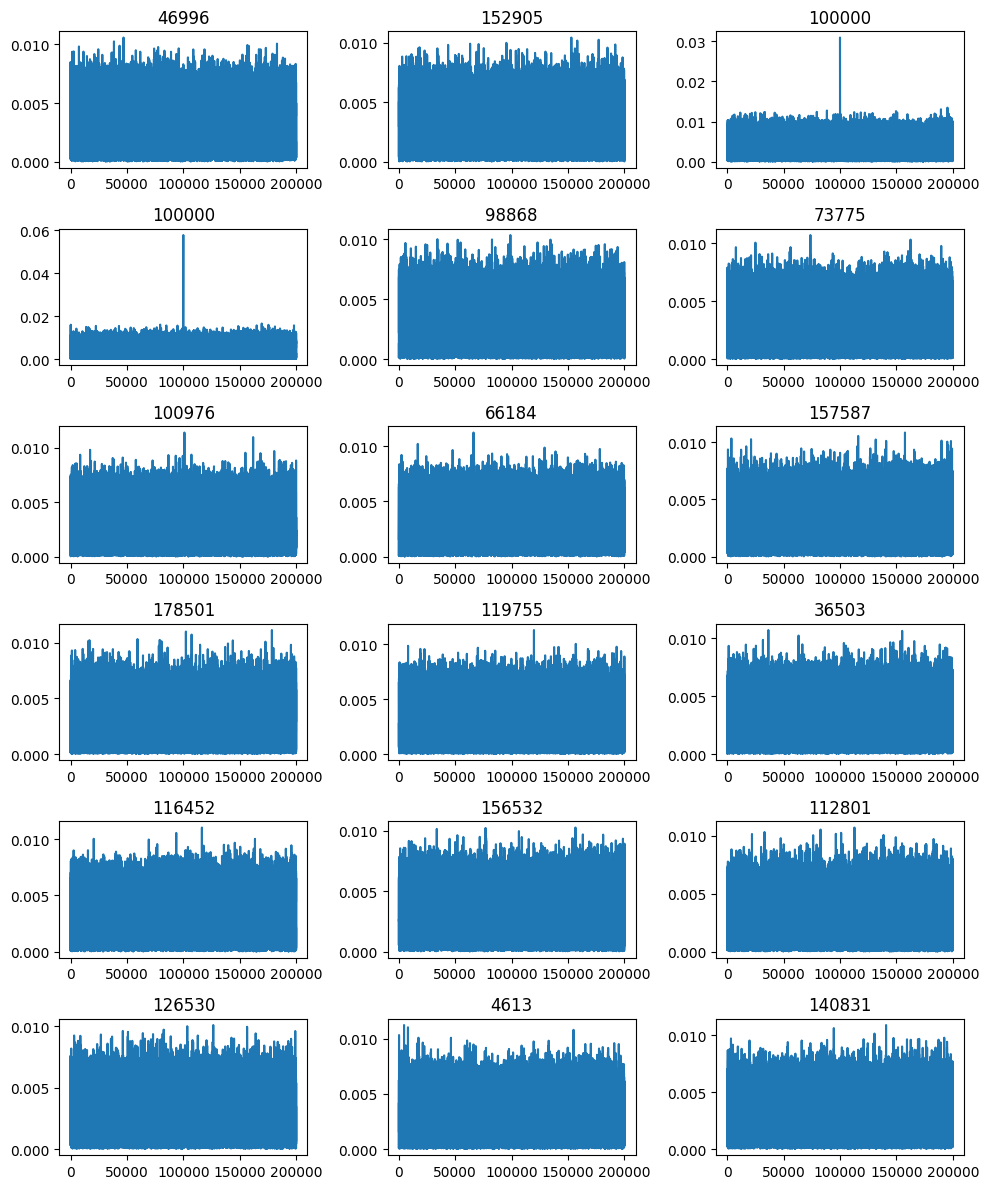

In [13]:
'''
Here we plot all of the channels we are looking at
The title is the frequency with max correlation (I think?) highest peak visually

So the only really clear ones are 109993, in subsequent channels

Note that the figure x-axis has center at 3 million, as this is the zero frequency
We only look at the 100 000 closest.
'''

center=3000000  #half the total number of points
dN=100000
fig,ax=plt.subplots(6,3)
fig.set_size_inches(10,12)
ax=ax.flatten()
for cc in range(nchans):
    mm=np.argmax(np.abs(xc[cc,center-dN:center+dN]))
    ax[cc].set_title(f"{mm}")
    ax[cc].plot(np.abs(xc[cc,center-dN:center+dN]))
plt.tight_layout()

(65984.0, 66384.0)

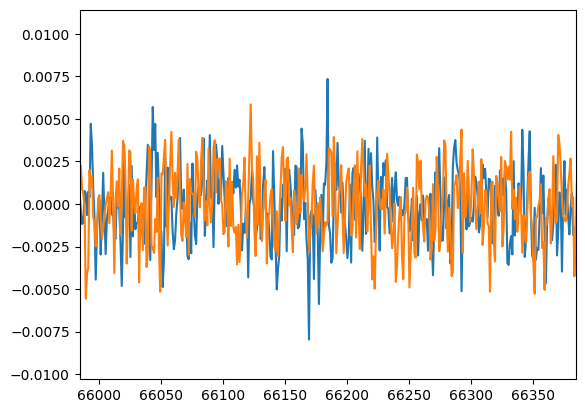

In [16]:
cc=7
mm=np.argmax(np.abs(xc[cc,center-dN:center+dN]))
plt.plot(np.real(xc[cc,center-dN:center+dN]))
plt.plot(np.real(xc[16,center-dN:center+dN]))

plt.xlim(mm-200,mm+200)

In [ ]:
outils.chan2freq(np.arange(1834,1834+18),alias=True)/1e6 - 0.061/2

array([138.03102344, 137.96998828, 137.90895313, 137.84791797,
       137.78688281, 137.72584766, 137.6648125 , 137.60377734,
       137.54274219, 137.48170703, 137.42067188, 137.35963672,
       137.29860156, 137.23756641, 137.17653125, 137.11549609,
       137.05446094, 136.99342578])

Text(0.5, 0, 'units of 0.3 Hz')

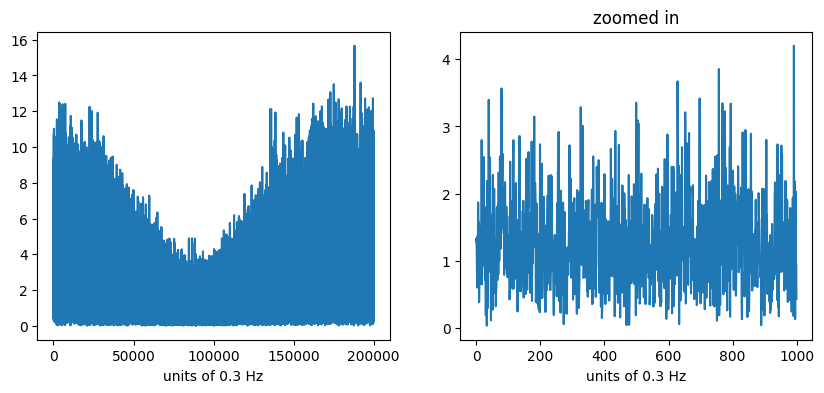

In [ ]:
spec=np.fft.fft(xc[3,center-dN:center+dN])
f=plt.gcf()
f.set_size_inches(10,4)
plt.subplot(121)
plt.plot(np.abs(spec))
plt.xlabel("units of 0.3 Hz")
plt.subplot(122)
plt.title("zoomed in")
plt.plot(np.abs(spec)[79000:80000])
plt.xlabel("units of 0.3 Hz")

In [ ]:
a1_coords = [79+25.031/60, -90-46.041/60, 189]  # MARS 1
a2_coords = [79+25.033/60, -90-45.531/60, 176]  # MARS 2
print(a1_coords)
tle_path = outils.get_tle_file(1721800002, "/project/s/sievers/mohanagr/OCOMM_TLES")
rsats = outils.get_risen_sats(tle_path, a1_coords, 1721800002, dt=5, niter=3600*24//5,altitude_cutoff=15)

[79.41718333333333, -90.76735, 189]
starting at  1721800002 dt is 5


Text(0.5, 0, 'sec')

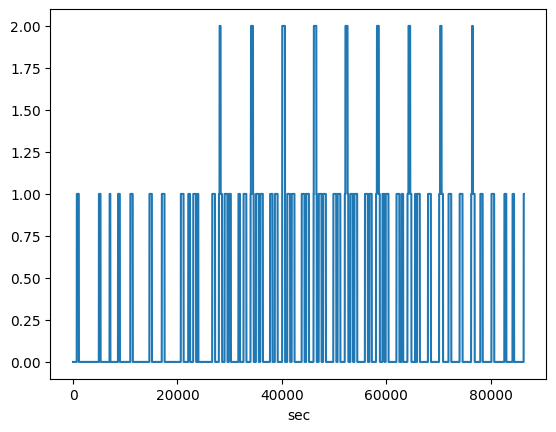

In [ ]:
num_sats_risen = [len(x) for x in rsats]
plt.plot(np.arange(len(rsats))*5,num_sats_risen)
plt.xlabel("sec")
# plt.xlim(0,20000)

In [ ]:
gaps=outils.find_pulses(np.asarray(num_sats_risen))
gaplen=[(gap[1]-gap[0])*5/60 for gap in gaps]

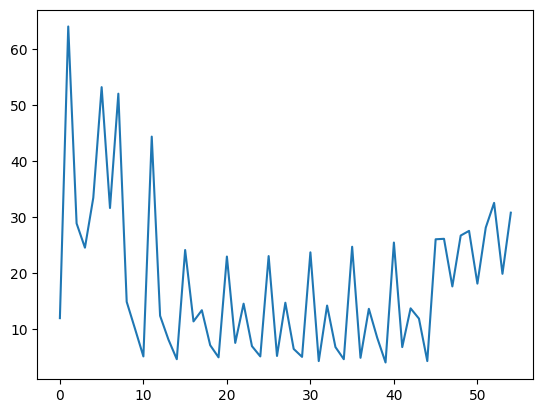

In [ ]:
plt.plot(gaplen)

In [ ]:
np.median(gaplen), np.mean(gaplen)

(10.416666666666666, 11.082191780821917)

In [ ]:
satnums=[]
for s in rsats:
    if len(s)>0:
        for j in range(len(s)):
            satnums.append(s[j][0])

In [ ]:
set(satnums)

{25338, 28654, 33591, 44387, 57166, 59051}

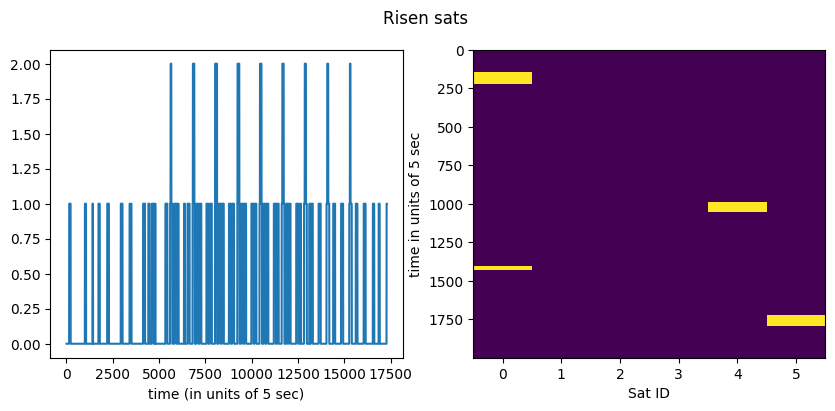

In [ ]:
satlist=[28654,25338,33591,57166,59051,44387]
satmap = {}
assert min(satlist) > len(
    satlist
)  # to make sure there are no collisions, we'll never have an i that's also a satnum
for i, satnum in enumerate(satlist):
    satmap[i] = satnum
    satmap[satnum] = i
arr = np.zeros((len(rsats), len(satlist)), dtype="int64")
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,4)
fig.suptitle(f"Risen sats")
ax[0].plot(num_sats_risen)
ax[0].set_xlabel("time (in units of 5 sec)")
for i, row in enumerate(rsats):
    for satnum, satele,sataz in row:
        arr[i][satmap[satnum]] = 1
ax[1].set_ylabel("time in units of 5 sec")
ax[1].set_xlabel("Sat ID")
ax[1].imshow(arr[:2000],aspect='auto',interpolation="none")

In [ ]:
satmap

{0: 28654,
 28654: 0,
 1: 25338,
 25338: 1,
 2: 33591,
 33591: 2,
 3: 57166,
 57166: 3,
 4: 59051,
 59051: 4,
 5: 44387,
 44387: 5}

In [ ]:
m1=ant1.spec_num_start
m2=ant2.spec_num_start
print(m1,m2)

1294978843 1351222502


In [ ]:
channels[ant1.channel_idxs]

array([1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844,
       1845, 1846, 1847, 1848, 1849, 1850, 1851])

In [ ]:
# freqs=outils.chan2freq(channels,alias=True)
# freqs=outils.chan2freq(np.asarray([1840,1844]),alias=True)
m1=ant1.spec_num_start
m2=ant2.spec_num_start
visibility_phased = np.zeros((nchunks,len(ant1.channel_idxs)), dtype='complex64')
st=time.time()
for i, (chunk1,chunk2) in enumerate(zip(ant1,ant2)):
        # pol00[i,:] = cr.avg_xcorr_4bit_2ant(chunk1['pol0'], chunk2['pol0'],chnk1['specnums'],chunk2['specnums'],m1+i*acclen,m2+i*acclen)
        xcorr=avg_xcorr_4bit_2ant_float(chunk1['pol0'], chunk2['pol0'],chunk1['specnums'],chunk2['specnums'],m1+i*acclen,m2+i*acclen)
        visibility_phased[i,:] = np.sum(xcorr,axis=0)/acclen
        print("CHUNK", i, " has ", xcorr.shape[0], " rows")
print("Time taken final:", time.time()-st)
visibility_phased = np.ma.masked_invalid(visibility_phased)

CHUNK 0  has  30000  rows
CHUNK 1  has  30000  rows
CHUNK 2  has  30000  rows
CHUNK 3  has  30000  rows
CHUNK 4  has  30000  rows
CHUNK 5  has  30000  rows
CHUNK 6  has  30000  rows
CHUNK 7  has  30000  rows
CHUNK 8  has  30000  rows
CHUNK 9  has  30000  rows
CHUNK 10  has  30000  rows
CHUNK 11  has  30000  rows
CHUNK 12  has  30000  rows
CHUNK 13  has  30000  rows
CHUNK 14  has  30000  rows
CHUNK 15  has  30000  rows
CHUNK 16  has  30000  rows
CHUNK 17  has  30000  rows
CHUNK 18  has  30000  rows
CHUNK 19  has  30000  rows
CHUNK 20  has  30000  rows
CHUNK 21  has  30000  rows
CHUNK 22  has  30000  rows
CHUNK 23  has  30000  rows
CHUNK 24  has  30000  rows
CHUNK 25  has  30000  rows
CHUNK 26  has  30000  rows
CHUNK 27  has  30000  rows
CHUNK 28  has  30000  rows
CHUNK 29  has  30000  rows
took 0.547 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805018.raw
overflow counter is  0
spec idx is [1295907802 1295907803 1295907804 ... 1298616771 1298616

CHUNK 260  has  30000  rows
CHUNK 261  has  30000  rows
CHUNK 262  has  30000  rows
CHUNK 263  has  30000  rows
CHUNK 264  has  30000  rows
CHUNK 265  has  30000  rows
CHUNK 266  has  30000  rows
CHUNK 267  has  30000  rows
CHUNK 268  has  30000  rows
CHUNK 269  has  30000  rows
CHUNK 270  has  30000  rows
CHUNK 271  has  30000  rows
CHUNK 272  has  30000  rows
CHUNK 273  has  30000  rows
CHUNK 274  has  30000  rows
CHUNK 275  has  30000  rows
CHUNK 276  has  30000  rows
CHUNK 277  has  30000  rows
CHUNK 278  has  30000  rows
CHUNK 279  has  30000  rows
CHUNK 280  has  30000  rows
CHUNK 281  has  30000  rows
CHUNK 282  has  30000  rows
CHUNK 283  has  30000  rows
CHUNK 284  has  30000  rows
CHUNK 285  has  30000  rows
CHUNK 286  has  30000  rows
CHUNK 287  has  30000  rows
CHUNK 288  has  30000  rows
CHUNK 289  has  30000  rows
CHUNK 290  has  30000  rows
CHUNK 291  has  30000  rows
CHUNK 292  has  30000  rows
CHUNK 293  has  30000  rows
CHUNK 294  has  30000  rows
CHUNK 295  has  3000

took 1.595 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721805256.raw
overflow counter is  0
spec idx is [1366682877 1366682878 1366682879 ... 1369391846 1369391847 1369391848]
CHUNK 515  has  30000  rows
CHUNK 516  has  30000  rows
CHUNK 517  has  30000  rows
CHUNK 518  has  30000  rows
CHUNK 519  has  30000  rows
CHUNK 520  has  30000  rows
CHUNK 521  has  30000  rows
CHUNK 522  has  30000  rows
CHUNK 523  has  30000  rows
CHUNK 524  has  30000  rows
CHUNK 525  has  30000  rows
CHUNK 526  has  30000  rows
CHUNK 527  has  30000  rows
CHUNK 528  has  30000  rows
CHUNK 529  has  30000  rows
CHUNK 530  has  30000  rows
CHUNK 531  has  30000  rows
CHUNK 532  has  30000  rows
CHUNK 533  has  30000  rows
CHUNK 534  has  30000  rows
CHUNK 535  has  30000  rows
CHUNK 536  has  30000  rows
CHUNK 537  has  30000  rows
CHUNK 538  has  30000  rows
CHUNK 539  has  30000  rows
CHUNK 540  has  30000  rows
CHUNK 541  has  30000  rows
CHUNK 542  has  30000  rows


CHUNK 769  has  30000  rows
CHUNK 770  has  30000  rows
CHUNK 771  has  30000  rows
CHUNK 772  has  30000  rows
CHUNK 773  has  30000  rows
CHUNK 774  has  30000  rows
CHUNK 775  has  30000  rows
CHUNK 776  has  30000  rows
CHUNK 777  has  30000  rows
CHUNK 778  has  30000  rows
CHUNK 779  has  30000  rows
CHUNK 780  has  30000  rows
CHUNK 781  has  30000  rows
CHUNK 782  has  30000  rows
CHUNK 783  has  30000  rows
CHUNK 784  has  30000  rows
CHUNK 785  has  30000  rows
took 1.834 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721805389.raw
overflow counter is  0
spec idx is [1374809793 1374809794 1374809795 ... 1377518762 1377518763 1377518764]
CHUNK 786  has  30000  rows
CHUNK 787  has  30000  rows
CHUNK 788  has  30000  rows
CHUNK 789  has  30000  rows
CHUNK 790  has  30000  rows
CHUNK 791  has  30000  rows
CHUNK 792  has  30000  rows
CHUNK 793  has  30000  rows
CHUNK 794  has  30000  rows
CHUNK 795  has  30000  rows
CHUNK 796  has  30000  rows


took 1.598 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805506.raw
overflow counter is  0
spec idx is [1325706494 1325706495 1325706496 ... 1328415463 1328415464 1328415465]
CHUNK 1024  has  30000  rows
CHUNK 1025  has  30000  rows
CHUNK 1026  has  30000  rows
CHUNK 1027  has  30000  rows
CHUNK 1028  has  30000  rows
CHUNK 1029  has  30000  rows
CHUNK 1030  has  30000  rows
CHUNK 1031  has  30000  rows
CHUNK 1032  has  30000  rows
CHUNK 1033  has  30000  rows
CHUNK 1034  has  30000  rows
CHUNK 1035  has  30000  rows
CHUNK 1036  has  30000  rows
CHUNK 1037  has  30000  rows
CHUNK 1038  has  30000  rows
CHUNK 1039  has  30000  rows
CHUNK 1040  has  30000  rows
CHUNK 1041  has  30000  rows
CHUNK 1042  has  30000  rows
CHUNK 1043  has  30000  rows
CHUNK 1044  has  30000  rows
CHUNK 1045  has  30000  rows
CHUNK 1046  has  30000  rows
CHUNK 1047  has  30000  rows
CHUNK 1048  has  30000  rows
CHUNK 1049  has  30000  rows
CHUNK 1050  has  30000  rows
C

CHUNK 1267  has  30000  rows
CHUNK 1268  has  30000  rows
CHUNK 1269  has  30000  rows
CHUNK 1270  has  30000  rows
CHUNK 1271  has  30000  rows
CHUNK 1272  has  30000  rows
CHUNK 1273  has  30000  rows
CHUNK 1274  has  30000  rows
CHUNK 1275  has  30000  rows
CHUNK 1276  has  30000  rows
CHUNK 1277  has  30000  rows
CHUNK 1278  has  30000  rows
CHUNK 1279  has  30000  rows
CHUNK 1280  has  30000  rows
CHUNK 1281  has  30000  rows
CHUNK 1282  has  30000  rows
CHUNK 1283  has  30000  rows
CHUNK 1284  has  30000  rows
CHUNK 1285  has  30000  rows
CHUNK 1286  has  30000  rows
CHUNK 1287  has  30000  rows
CHUNK 1288  has  30000  rows
CHUNK 1289  has  30000  rows
CHUNK 1290  has  30000  rows
CHUNK 1291  has  30000  rows
CHUNK 1292  has  30000  rows
CHUNK 1293  has  30000  rows
CHUNK 1294  has  30000  rows
took 1.550 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805639.raw
overflow counter is  0
spec idx is [1333833410 1333833411 1333833412 ... 133654

CHUNK 1509  has  30000  rows
CHUNK 1510  has  30000  rows
CHUNK 1511  has  30000  rows
CHUNK 1512  has  30000  rows
CHUNK 1513  has  30000  rows
CHUNK 1514  has  30000  rows
CHUNK 1515  has  30000  rows
CHUNK 1516  has  30000  rows
CHUNK 1517  has  30000  rows
CHUNK 1518  has  30000  rows
CHUNK 1519  has  30000  rows
CHUNK 1520  has  30000  rows
CHUNK 1521  has  30000  rows
CHUNK 1522  has  30000  rows
CHUNK 1523  has  30000  rows
CHUNK 1524  has  30000  rows
CHUNK 1525  has  30000  rows
CHUNK 1526  has  30000  rows
CHUNK 1527  has  30000  rows
CHUNK 1528  has  30000  rows
CHUNK 1529  has  30000  rows
CHUNK 1530  has  30000  rows
CHUNK 1531  has  30000  rows
CHUNK 1532  has  30000  rows
CHUNK 1533  has  30000  rows
CHUNK 1534  has  30000  rows
CHUNK 1535  has  30000  rows
CHUNK 1536  has  30000  rows
CHUNK 1537  has  30000  rows
CHUNK 1538  has  30000  rows
CHUNK 1539  has  30000  rows
CHUNK 1540  has  30000  rows
CHUNK 1541  has  30000  rows
CHUNK 1542  has  30000  rows
CHUNK 1543  ha

CHUNK 1761  has  30000  rows
CHUNK 1762  has  30000  rows
CHUNK 1763  has  30000  rows
CHUNK 1764  has  30000  rows
CHUNK 1765  has  30000  rows
CHUNK 1766  has  30000  rows
CHUNK 1767  has  30000  rows
CHUNK 1768  has  30000  rows
CHUNK 1769  has  30000  rows
CHUNK 1770  has  30000  rows
CHUNK 1771  has  30000  rows
CHUNK 1772  has  30000  rows
CHUNK 1773  has  30000  rows
CHUNK 1774  has  30000  rows
CHUNK 1775  has  30000  rows
CHUNK 1776  has  30000  rows
CHUNK 1777  has  30000  rows
CHUNK 1778  has  30000  rows
took 1.647 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721805877.raw
overflow counter is  0
spec idx is [1404608485 1404608486 1404608487 ... 1407317454 1407317455 1407317456]
CHUNK 1779  has  30000  rows
CHUNK 1780  has  30000  rows
CHUNK 1781  has  30000  rows
CHUNK 1782  has  30000  rows
CHUNK 1783  has  30000  rows
CHUNK 1784  has  30000  rows
CHUNK 1785  has  30000  rows
CHUNK 1786  has  30000  rows
CHUNK 1787  has  30000  rows
C

took 1.514 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721805994.raw
overflow counter is  0
spec idx is [1355505186 1355505187 1355505188 ... 1358214155 1358214156 1358214157]
CHUNK 2017  has  30000  rows
CHUNK 2018  has  30000  rows
CHUNK 2019  has  30000  rows
CHUNK 2020  has  30000  rows
CHUNK 2021  has  30000  rows
CHUNK 2022  has  30000  rows
CHUNK 2023  has  30000  rows
CHUNK 2024  has  30000  rows
CHUNK 2025  has  30000  rows
CHUNK 2026  has  30000  rows
CHUNK 2027  has  30000  rows
CHUNK 2028  has  30000  rows
CHUNK 2029  has  30000  rows
CHUNK 2030  has  30000  rows
CHUNK 2031  has  30000  rows
CHUNK 2032  has  30000  rows
CHUNK 2033  has  30000  rows
CHUNK 2034  has  30000  rows
CHUNK 2035  has  30000  rows
CHUNK 2036  has  30000  rows
CHUNK 2037  has  30000  rows
CHUNK 2038  has  30000  rows
CHUNK 2039  has  30000  rows
CHUNK 2040  has  30000  rows
CHUNK 2041  has  30000  rows
CHUNK 2042  has  30000  rows
CHUNK 2043  has  30000  rows
C

CHUNK 2260  has  30000  rows
CHUNK 2261  has  30000  rows
CHUNK 2262  has  30000  rows
CHUNK 2263  has  30000  rows
CHUNK 2264  has  30000  rows
CHUNK 2265  has  30000  rows
CHUNK 2266  has  30000  rows
CHUNK 2267  has  30000  rows
CHUNK 2268  has  30000  rows
CHUNK 2269  has  30000  rows
CHUNK 2270  has  30000  rows
CHUNK 2271  has  30000  rows
CHUNK 2272  has  30000  rows
CHUNK 2273  has  30000  rows
CHUNK 2274  has  30000  rows
CHUNK 2275  has  30000  rows
CHUNK 2276  has  30000  rows
CHUNK 2277  has  30000  rows
CHUNK 2278  has  30000  rows
CHUNK 2279  has  30000  rows
CHUNK 2280  has  30000  rows
CHUNK 2281  has  30000  rows
CHUNK 2282  has  30000  rows
CHUNK 2283  has  30000  rows
CHUNK 2284  has  30000  rows
CHUNK 2285  has  30000  rows
CHUNK 2286  has  30000  rows
CHUNK 2287  has  30000  rows
took 1.516 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721806127.raw
overflow counter is  0
spec idx is [1363632102 1363632103 1363632104 ... 136634

CHUNK 2502  has  30000  rows
CHUNK 2503  has  30000  rows
CHUNK 2504  has  30000  rows
CHUNK 2505  has  30000  rows
CHUNK 2506  has  30000  rows
CHUNK 2507  has  30000  rows
CHUNK 2508  has  30000  rows
CHUNK 2509  has  30000  rows
CHUNK 2510  has  30000  rows
CHUNK 2511  has  30000  rows
CHUNK 2512  has  30000  rows
CHUNK 2513  has  30000  rows
CHUNK 2514  has  30000  rows
CHUNK 2515  has  30000  rows
CHUNK 2516  has  30000  rows
CHUNK 2517  has  30000  rows
CHUNK 2518  has  30000  rows
CHUNK 2519  has  30000  rows
CHUNK 2520  has  30000  rows
CHUNK 2521  has  30000  rows
CHUNK 2522  has  30000  rows
CHUNK 2523  has  30000  rows
CHUNK 2524  has  30000  rows
CHUNK 2525  has  30000  rows
CHUNK 2526  has  30000  rows
CHUNK 2527  has  30000  rows
CHUNK 2528  has  30000  rows
CHUNK 2529  has  30000  rows
CHUNK 2530  has  30000  rows
CHUNK 2531  has  30000  rows
CHUNK 2532  has  30000  rows
CHUNK 2533  has  30000  rows
CHUNK 2534  has  30000  rows
CHUNK 2535  has  30000  rows
CHUNK 2536  ha

CHUNK 2754  has  30000  rows
CHUNK 2755  has  30000  rows
CHUNK 2756  has  30000  rows
CHUNK 2757  has  30000  rows
CHUNK 2758  has  30000  rows
CHUNK 2759  has  30000  rows
CHUNK 2760  has  30000  rows
CHUNK 2761  has  30000  rows
CHUNK 2762  has  30000  rows
CHUNK 2763  has  30000  rows
CHUNK 2764  has  30000  rows
CHUNK 2765  has  30000  rows
CHUNK 2766  has  30000  rows
CHUNK 2767  has  30000  rows
CHUNK 2768  has  30000  rows
CHUNK 2769  has  30000  rows
CHUNK 2770  has  30000  rows
CHUNK 2771  has  30000  rows
took 1.490 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721806365.raw
overflow counter is  0
spec idx is [1434407177 1434407178 1434407179 ... 1437116146 1437116147 1437116148]
CHUNK 2772  has  30000  rows
CHUNK 2773  has  30000  rows
CHUNK 2774  has  30000  rows
CHUNK 2775  has  30000  rows
CHUNK 2776  has  30000  rows
CHUNK 2777  has  30000  rows
CHUNK 2778  has  30000  rows
CHUNK 2779  has  30000  rows
CHUNK 2780  has  30000  rows
C

took 1.635 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721806482.raw
overflow counter is  0
spec idx is [1385303878 1385303879 1385303880 ... 1388012847 1388012848 1388012849]
CHUNK 3010  has  30000  rows
CHUNK 3011  has  30000  rows
CHUNK 3012  has  30000  rows
CHUNK 3013  has  30000  rows
CHUNK 3014  has  30000  rows
CHUNK 3015  has  30000  rows
CHUNK 3016  has  30000  rows
CHUNK 3017  has  30000  rows
CHUNK 3018  has  30000  rows
CHUNK 3019  has  30000  rows
CHUNK 3020  has  30000  rows
CHUNK 3021  has  30000  rows
CHUNK 3022  has  30000  rows
CHUNK 3023  has  30000  rows
CHUNK 3024  has  30000  rows
CHUNK 3025  has  30000  rows
CHUNK 3026  has  30000  rows
CHUNK 3027  has  30000  rows
CHUNK 3028  has  30000  rows
CHUNK 3029  has  30000  rows
CHUNK 3030  has  30000  rows
CHUNK 3031  has  30000  rows
CHUNK 3032  has  30000  rows
CHUNK 3033  has  30000  rows
CHUNK 3034  has  30000  rows
CHUNK 3035  has  30000  rows
CHUNK 3036  has  30000  rows
C

CHUNK 3254  has  30000  rows
CHUNK 3255  has  30000  rows
CHUNK 3256  has  30000  rows
CHUNK 3257  has  30000  rows
CHUNK 3258  has  30000  rows
CHUNK 3259  has  30000  rows
CHUNK 3260  has  30000  rows
CHUNK 3261  has  30000  rows
CHUNK 3262  has  30000  rows
CHUNK 3263  has  30000  rows
CHUNK 3264  has  30000  rows
CHUNK 3265  has  30000  rows
CHUNK 3266  has  30000  rows
CHUNK 3267  has  30000  rows
CHUNK 3268  has  30000  rows
CHUNK 3269  has  30000  rows
CHUNK 3270  has  30000  rows
CHUNK 3271  has  30000  rows
CHUNK 3272  has  30000  rows
CHUNK 3273  has  30000  rows
CHUNK 3274  has  30000  rows
CHUNK 3275  has  30000  rows
CHUNK 3276  has  30000  rows
CHUNK 3277  has  30000  rows
CHUNK 3278  has  30000  rows
CHUNK 3279  has  30000  rows
CHUNK 3280  has  30000  rows
took 1.532 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721806615.raw
overflow counter is  0
spec idx is [1393430794 1393430795 1393430796 ... 1396139763 1396139764 1396139765]
C

CHUNK 3495  has  30000  rows
CHUNK 3496  has  30000  rows
CHUNK 3497  has  30000  rows
CHUNK 3498  has  30000  rows
CHUNK 3499  has  30000  rows
CHUNK 3500  has  30000  rows
CHUNK 3501  has  30000  rows
CHUNK 3502  has  30000  rows
CHUNK 3503  has  30000  rows
CHUNK 3504  has  30000  rows
CHUNK 3505  has  30000  rows
CHUNK 3506  has  30000  rows
CHUNK 3507  has  30000  rows
CHUNK 3508  has  30000  rows
CHUNK 3509  has  30000  rows
CHUNK 3510  has  30000  rows
CHUNK 3511  has  30000  rows
CHUNK 3512  has  30000  rows
CHUNK 3513  has  30000  rows
CHUNK 3514  has  30000  rows
CHUNK 3515  has  30000  rows
CHUNK 3516  has  30000  rows
CHUNK 3517  has  30000  rows
CHUNK 3518  has  30000  rows
CHUNK 3519  has  30000  rows
CHUNK 3520  has  30000  rows
CHUNK 3521  has  30000  rows
CHUNK 3522  has  30000  rows
CHUNK 3523  has  30000  rows
CHUNK 3524  has  30000  rows
CHUNK 3525  has  30000  rows
CHUNK 3526  has  30000  rows
CHUNK 3527  has  30000  rows
CHUNK 3528  has  30000  rows
CHUNK 3529  ha

CHUNK 3746  has  30000  rows
CHUNK 3747  has  30000  rows
CHUNK 3748  has  30000  rows
CHUNK 3749  has  30000  rows
CHUNK 3750  has  30000  rows
CHUNK 3751  has  30000  rows
CHUNK 3752  has  30000  rows
CHUNK 3753  has  30000  rows
CHUNK 3754  has  30000  rows
CHUNK 3755  has  30000  rows
CHUNK 3756  has  30000  rows
CHUNK 3757  has  30000  rows
CHUNK 3758  has  30000  rows
CHUNK 3759  has  30000  rows
CHUNK 3760  has  30000  rows
CHUNK 3761  has  30000  rows
CHUNK 3762  has  30000  rows
CHUNK 3763  has  30000  rows
CHUNK 3764  has  30000  rows
CHUNK 3765  has  30000  rows
took 1.629 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721806854.raw
overflow counter is  0
spec idx is [1464205869 1464205870 1464205871 ... 1466914838 1466914839 1466914840]
CHUNK 3766  has  30000  rows
CHUNK 3767  has  30000  rows
CHUNK 3768  has  30000  rows
CHUNK 3769  has  30000  rows
CHUNK 3770  has  30000  rows
CHUNK 3771  has  30000  rows
CHUNK 3772  has  30000  rows
C

CHUNK 4000  has  30000  rows
CHUNK 4001  has  30000  rows
CHUNK 4002  has  30000  rows
CHUNK 4003  has  30000  rows
took 1.558 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721806971.raw
overflow counter is  0
spec idx is [1415102570 1415102571 1415102572 ... 1417811539 1417811540 1417811541]
CHUNK 4004  has  30000  rows
CHUNK 4005  has  30000  rows
CHUNK 4006  has  30000  rows
CHUNK 4007  has  30000  rows
CHUNK 4008  has  30000  rows
CHUNK 4009  has  30000  rows
CHUNK 4010  has  30000  rows
CHUNK 4011  has  30000  rows
CHUNK 4012  has  30000  rows
CHUNK 4013  has  30000  rows
CHUNK 4014  has  30000  rows
CHUNK 4015  has  30000  rows
CHUNK 4016  has  30000  rows
CHUNK 4017  has  30000  rows
CHUNK 4018  has  30000  rows
CHUNK 4019  has  30000  rows
CHUNK 4020  has  30000  rows
CHUNK 4021  has  30000  rows
CHUNK 4022  has  30000  rows
CHUNK 4023  has  30000  rows
CHUNK 4024  has  30000  rows
CHUNK 4025  has  30000  rows
CHUNK 4026  has  30000  rows
C

CHUNK 4247  has  30000  rows
CHUNK 4248  has  30000  rows
CHUNK 4249  has  30000  rows
CHUNK 4250  has  30000  rows
CHUNK 4251  has  30000  rows
CHUNK 4252  has  30000  rows
CHUNK 4253  has  30000  rows
CHUNK 4254  has  30000  rows
CHUNK 4255  has  30000  rows
CHUNK 4256  has  30000  rows
CHUNK 4257  has  30000  rows
CHUNK 4258  has  30000  rows
CHUNK 4259  has  30000  rows
CHUNK 4260  has  30000  rows
CHUNK 4261  has  30000  rows
CHUNK 4262  has  30000  rows
CHUNK 4263  has  30000  rows
CHUNK 4264  has  30000  rows
CHUNK 4265  has  30000  rows
CHUNK 4266  has  30000  rows
CHUNK 4267  has  30000  rows
CHUNK 4268  has  30000  rows
CHUNK 4269  has  30000  rows
CHUNK 4270  has  30000  rows
CHUNK 4271  has  30000  rows
CHUNK 4272  has  30000  rows
CHUNK 4273  has  30000  rows
CHUNK 4274  has  30000  rows
took 1.522 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721807104.raw
overflow counter is  0
spec idx is [1423229486 1423229487 1423229488 ... 142593

CHUNK 4489  has  30000  rows
CHUNK 4490  has  30000  rows
CHUNK 4491  has  30000  rows
CHUNK 4492  has  30000  rows
CHUNK 4493  has  30000  rows
CHUNK 4494  has  30000  rows
CHUNK 4495  has  30000  rows
CHUNK 4496  has  30000  rows
CHUNK 4497  has  30000  rows
CHUNK 4498  has  30000  rows
CHUNK 4499  has  30000  rows
CHUNK 4500  has  30000  rows
CHUNK 4501  has  30000  rows
CHUNK 4502  has  30000  rows
CHUNK 4503  has  30000  rows
CHUNK 4504  has  30000  rows
CHUNK 4505  has  30000  rows
CHUNK 4506  has  30000  rows
CHUNK 4507  has  30000  rows
CHUNK 4508  has  30000  rows
CHUNK 4509  has  30000  rows
CHUNK 4510  has  30000  rows
CHUNK 4511  has  30000  rows
CHUNK 4512  has  30000  rows
CHUNK 4513  has  30000  rows
CHUNK 4514  has  30000  rows
CHUNK 4515  has  30000  rows
CHUNK 4516  has  30000  rows
CHUNK 4517  has  30000  rows
CHUNK 4518  has  30000  rows
CHUNK 4519  has  30000  rows
CHUNK 4520  has  30000  rows
CHUNK 4521  has  30000  rows
CHUNK 4522  has  30000  rows
CHUNK 4523  ha

CHUNK 4740  has  30000  rows
CHUNK 4741  has  30000  rows
CHUNK 4742  has  30000  rows
CHUNK 4743  has  30000  rows
CHUNK 4744  has  30000  rows
CHUNK 4745  has  30000  rows
CHUNK 4746  has  30000  rows
CHUNK 4747  has  30000  rows
CHUNK 4748  has  30000  rows
CHUNK 4749  has  30000  rows
CHUNK 4750  has  30000  rows
CHUNK 4751  has  30000  rows
CHUNK 4752  has  30000  rows
CHUNK 4753  has  30000  rows
CHUNK 4754  has  30000  rows
CHUNK 4755  has  30000  rows
CHUNK 4756  has  30000  rows
CHUNK 4757  has  30000  rows
CHUNK 4758  has  30000  rows
took 1.510 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721807342.raw
overflow counter is  0
spec idx is [1494004561 1494004562 1494004563 ... 1496713530 1496713531 1496713532]
CHUNK 4759  has  30000  rows
CHUNK 4760  has  30000  rows
CHUNK 4761  has  30000  rows
CHUNK 4762  has  30000  rows
CHUNK 4763  has  30000  rows
CHUNK 4764  has  30000  rows
CHUNK 4765  has  30000  rows
CHUNK 4766  has  30000  rows
C

CHUNK 4989  has  30000  rows
CHUNK 4990  has  30000  rows
CHUNK 4991  has  30000  rows
CHUNK 4992  has  30000  rows
CHUNK 4993  has  30000  rows
CHUNK 4994  has  30000  rows
CHUNK 4995  has  30000  rows
CHUNK 4996  has  30000  rows
took 1.634 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721807459.raw
overflow counter is  0
spec idx is [1444901262 1444901263 1444901264 ... 1447610231 1447610232 1447610233]
CHUNK 4997  has  30000  rows
CHUNK 4998  has  30000  rows
CHUNK 4999  has  30000  rows
CHUNK 5000  has  30000  rows
CHUNK 5001  has  30000  rows
CHUNK 5002  has  30000  rows
CHUNK 5003  has  30000  rows
CHUNK 5004  has  30000  rows
CHUNK 5005  has  30000  rows
CHUNK 5006  has  30000  rows
CHUNK 5007  has  30000  rows
CHUNK 5008  has  30000  rows
CHUNK 5009  has  30000  rows
CHUNK 5010  has  30000  rows
CHUNK 5011  has  30000  rows
CHUNK 5012  has  30000  rows
CHUNK 5013  has  30000  rows
CHUNK 5014  has  30000  rows
CHUNK 5015  has  30000  rows
C

CHUNK 5241  has  30000  rows
CHUNK 5242  has  30000  rows
CHUNK 5243  has  30000  rows
CHUNK 5244  has  30000  rows
CHUNK 5245  has  30000  rows
CHUNK 5246  has  30000  rows
CHUNK 5247  has  30000  rows
CHUNK 5248  has  30000  rows
CHUNK 5249  has  30000  rows
CHUNK 5250  has  30000  rows
CHUNK 5251  has  30000  rows
CHUNK 5252  has  30000  rows
CHUNK 5253  has  30000  rows
CHUNK 5254  has  30000  rows
CHUNK 5255  has  30000  rows
CHUNK 5256  has  30000  rows
CHUNK 5257  has  30000  rows
CHUNK 5258  has  30000  rows
CHUNK 5259  has  30000  rows
CHUNK 5260  has  30000  rows
CHUNK 5261  has  30000  rows
CHUNK 5262  has  30000  rows
CHUNK 5263  has  30000  rows
CHUNK 5264  has  30000  rows
CHUNK 5265  has  30000  rows
CHUNK 5266  has  30000  rows
CHUNK 5267  has  30000  rows
took 1.507 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721807592.raw
overflow counter is  0
spec idx is [1453028178 1453028179 1453028180 ... 1455737147 1455737148 1455737149]
C

CHUNK 5482  has  30000  rows
CHUNK 5483  has  30000  rows
CHUNK 5484  has  30000  rows
CHUNK 5485  has  30000  rows
CHUNK 5486  has  30000  rows
CHUNK 5487  has  30000  rows
CHUNK 5488  has  30000  rows
CHUNK 5489  has  30000  rows
CHUNK 5490  has  30000  rows
CHUNK 5491  has  30000  rows
CHUNK 5492  has  30000  rows
CHUNK 5493  has  30000  rows
CHUNK 5494  has  30000  rows
CHUNK 5495  has  30000  rows
CHUNK 5496  has  30000  rows
CHUNK 5497  has  30000  rows
CHUNK 5498  has  30000  rows
CHUNK 5499  has  30000  rows
CHUNK 5500  has  30000  rows
CHUNK 5501  has  30000  rows
CHUNK 5502  has  30000  rows
CHUNK 5503  has  30000  rows
CHUNK 5504  has  30000  rows
CHUNK 5505  has  30000  rows
CHUNK 5506  has  30000  rows
CHUNK 5507  has  30000  rows
CHUNK 5508  has  30000  rows
CHUNK 5509  has  30000  rows
CHUNK 5510  has  30000  rows
CHUNK 5511  has  30000  rows
CHUNK 5512  has  30000  rows
CHUNK 5513  has  30000  rows
CHUNK 5514  has  30000  rows
CHUNK 5515  has  30000  rows
CHUNK 5516  ha

CHUNK 5736  has  30000  rows
CHUNK 5737  has  30000  rows
CHUNK 5738  has  30000  rows
CHUNK 5739  has  30000  rows
CHUNK 5740  has  30000  rows
CHUNK 5741  has  30000  rows
CHUNK 5742  has  30000  rows
CHUNK 5743  has  30000  rows
CHUNK 5744  has  30000  rows
CHUNK 5745  has  30000  rows
CHUNK 5746  has  30000  rows
CHUNK 5747  has  30000  rows
CHUNK 5748  has  30000  rows
CHUNK 5749  has  30000  rows
CHUNK 5750  has  30000  rows
CHUNK 5751  has  30000  rows
took 1.560 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721807830.raw
overflow counter is  0
spec idx is [1523803253 1523803254 1523803255 ... 1526512222 1526512223 1526512224]
CHUNK 5752  has  30000  rows
CHUNK 5753  has  30000  rows
CHUNK 5754  has  30000  rows
CHUNK 5755  has  30000  rows
CHUNK 5756  has  30000  rows
CHUNK 5757  has  30000  rows
CHUNK 5758  has  30000  rows
CHUNK 5759  has  30000  rows
CHUNK 5760  has  30000  rows
CHUNK 5761  has  30000  rows
CHUNK 5762  has  30000  rows
C

took 1.463 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721807947.raw
overflow counter is  0
spec idx is [1474699954 1474699955 1474699956 ... 1477408923 1477408924 1477408925]
CHUNK 5990  has  30000  rows
CHUNK 5991  has  30000  rows
CHUNK 5992  has  30000  rows
CHUNK 5993  has  30000  rows
CHUNK 5994  has  30000  rows
CHUNK 5995  has  30000  rows
CHUNK 5996  has  30000  rows
CHUNK 5997  has  30000  rows
CHUNK 5998  has  30000  rows
CHUNK 5999  has  30000  rows
CHUNK 6000  has  30000  rows
CHUNK 6001  has  30000  rows
CHUNK 6002  has  30000  rows
CHUNK 6003  has  30000  rows
CHUNK 6004  has  30000  rows
CHUNK 6005  has  30000  rows
CHUNK 6006  has  30000  rows
CHUNK 6007  has  30000  rows
CHUNK 6008  has  30000  rows
CHUNK 6009  has  30000  rows
CHUNK 6010  has  30000  rows
CHUNK 6011  has  30000  rows
CHUNK 6012  has  30000  rows
CHUNK 6013  has  30000  rows
CHUNK 6014  has  30000  rows
CHUNK 6015  has  30000  rows
CHUNK 6016  has  30000  rows
C

CHUNK 6234  has  30000  rows
CHUNK 6235  has  30000  rows
CHUNK 6236  has  30000  rows
CHUNK 6237  has  30000  rows
CHUNK 6238  has  30000  rows
CHUNK 6239  has  30000  rows
CHUNK 6240  has  30000  rows
CHUNK 6241  has  30000  rows
CHUNK 6242  has  30000  rows
CHUNK 6243  has  30000  rows
CHUNK 6244  has  30000  rows
CHUNK 6245  has  30000  rows
CHUNK 6246  has  30000  rows
CHUNK 6247  has  30000  rows
CHUNK 6248  has  30000  rows
CHUNK 6249  has  30000  rows
CHUNK 6250  has  30000  rows
CHUNK 6251  has  30000  rows
CHUNK 6252  has  30000  rows
CHUNK 6253  has  30000  rows
CHUNK 6254  has  30000  rows
CHUNK 6255  has  30000  rows
CHUNK 6256  has  30000  rows
CHUNK 6257  has  30000  rows
CHUNK 6258  has  30000  rows
CHUNK 6259  has  30000  rows
CHUNK 6260  has  30000  rows
took 1.504 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721808080.raw
overflow counter is  0
spec idx is [1482826870 1482826871 1482826872 ... 1485535839 1485535840 1485535841]
C

CHUNK 6476  has  30000  rows
CHUNK 6477  has  30000  rows
CHUNK 6478  has  30000  rows
CHUNK 6479  has  30000  rows
CHUNK 6480  has  30000  rows
CHUNK 6481  has  30000  rows
CHUNK 6482  has  30000  rows
CHUNK 6483  has  30000  rows
CHUNK 6484  has  30000  rows
CHUNK 6485  has  30000  rows
CHUNK 6486  has  30000  rows
CHUNK 6487  has  30000  rows
CHUNK 6488  has  30000  rows
CHUNK 6489  has  30000  rows
CHUNK 6490  has  30000  rows
CHUNK 6491  has  30000  rows
CHUNK 6492  has  30000  rows
CHUNK 6493  has  30000  rows
CHUNK 6494  has  30000  rows
CHUNK 6495  has  30000  rows
CHUNK 6496  has  30000  rows
CHUNK 6497  has  30000  rows
CHUNK 6498  has  30000  rows
CHUNK 6499  has  30000  rows
CHUNK 6500  has  30000  rows
CHUNK 6501  has  30000  rows
CHUNK 6502  has  30000  rows
CHUNK 6503  has  30000  rows
CHUNK 6504  has  30000  rows
CHUNK 6505  has  30000  rows
CHUNK 6506  has  30000  rows
CHUNK 6507  has  30000  rows
CHUNK 6508  has  30000  rows
CHUNK 6509  has  30000  rows
CHUNK 6510  ha

CHUNK 6729  has  30000  rows
CHUNK 6730  has  30000  rows
CHUNK 6731  has  30000  rows
CHUNK 6732  has  30000  rows
CHUNK 6733  has  30000  rows
CHUNK 6734  has  30000  rows
CHUNK 6735  has  30000  rows
CHUNK 6736  has  30000  rows
CHUNK 6737  has  30000  rows
CHUNK 6738  has  30000  rows
CHUNK 6739  has  30000  rows
CHUNK 6740  has  30000  rows
CHUNK 6741  has  30000  rows
CHUNK 6742  has  30000  rows
CHUNK 6743  has  30000  rows
CHUNK 6744  has  30000  rows
took 1.541 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721808318.raw
overflow counter is  0
spec idx is [1553601945 1553601946 1553601947 ... 1556310914 1556310915 1556310916]
CHUNK 6745  has  30000  rows
CHUNK 6746  has  30000  rows
CHUNK 6747  has  30000  rows
CHUNK 6748  has  30000  rows
CHUNK 6749  has  30000  rows
CHUNK 6750  has  30000  rows
CHUNK 6751  has  30000  rows
CHUNK 6752  has  30000  rows
CHUNK 6753  has  30000  rows
CHUNK 6754  has  30000  rows
CHUNK 6755  has  30000  rows
C

CHUNK 6978  has  30000  rows
CHUNK 6979  has  30000  rows
CHUNK 6980  has  30000  rows
CHUNK 6981  has  30000  rows
CHUNK 6982  has  30000  rows
took 1.454 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721808435.raw
overflow counter is  0
spec idx is [1504498646 1504498647 1504498648 ... 1507207615 1507207616 1507207617]
CHUNK 6983  has  30000  rows
CHUNK 6984  has  30000  rows
CHUNK 6985  has  30000  rows
CHUNK 6986  has  30000  rows
CHUNK 6987  has  30000  rows
CHUNK 6988  has  30000  rows
CHUNK 6989  has  30000  rows
CHUNK 6990  has  30000  rows
CHUNK 6991  has  30000  rows
CHUNK 6992  has  30000  rows
CHUNK 6993  has  30000  rows
CHUNK 6994  has  30000  rows
CHUNK 6995  has  30000  rows
CHUNK 6996  has  30000  rows
CHUNK 6997  has  30000  rows
CHUNK 6998  has  30000  rows
CHUNK 6999  has  30000  rows
CHUNK 7000  has  30000  rows
CHUNK 7001  has  30000  rows
CHUNK 7002  has  30000  rows
CHUNK 7003  has  30000  rows
CHUNK 7004  has  30000  rows
C

CHUNK 7226  has  30000  rows
CHUNK 7227  has  30000  rows
CHUNK 7228  has  30000  rows
CHUNK 7229  has  30000  rows
CHUNK 7230  has  30000  rows
CHUNK 7231  has  30000  rows
CHUNK 7232  has  30000  rows
CHUNK 7233  has  30000  rows
CHUNK 7234  has  30000  rows
CHUNK 7235  has  30000  rows
CHUNK 7236  has  30000  rows
CHUNK 7237  has  30000  rows
CHUNK 7238  has  30000  rows
CHUNK 7239  has  30000  rows
CHUNK 7240  has  30000  rows
CHUNK 7241  has  30000  rows
CHUNK 7242  has  30000  rows
CHUNK 7243  has  30000  rows
CHUNK 7244  has  30000  rows
CHUNK 7245  has  30000  rows
CHUNK 7246  has  30000  rows
CHUNK 7247  has  30000  rows
CHUNK 7248  has  30000  rows
CHUNK 7249  has  30000  rows
CHUNK 7250  has  30000  rows
CHUNK 7251  has  30000  rows
CHUNK 7252  has  30000  rows
CHUNK 7253  has  30000  rows
took 1.545 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721808568.raw
overflow counter is  0
spec idx is [1512625562 1512625563 1512625564 ... 151533

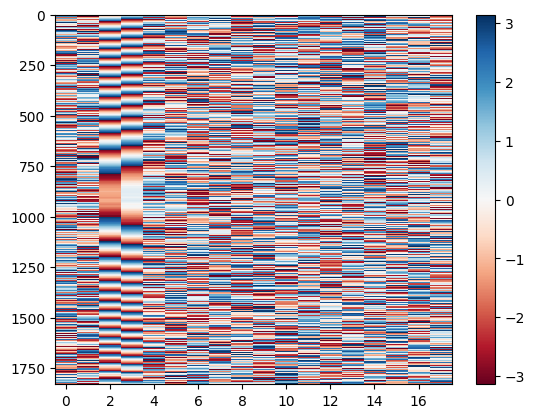

In [ ]:
vis_phase = np.angle(visibility_phased)
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:,:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

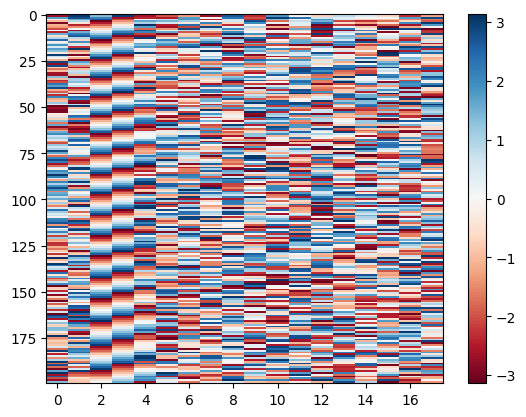

In [ ]:
vis_phase = np.angle(visibility_phased)
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:200,:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

In [ ]:
visibility_phased[:5,0]

masked_array(data=[(-0.007566666696220636-0.014433333650231361j),
                   (-0.031433332711458206-0.015233333222568035j),
                   (-0.007266666740179062+0.047066666185855865j),
                   (0.014833333902060986-0.004666666500270367j),
                   (0.01073333341628313-0.01626666635274887j)],
             mask=[False, False, False, False, False],
       fill_value=(1e+20+0j),
            dtype=complex64)

In [ ]:
t_start+3600*8.5

1721835602.0

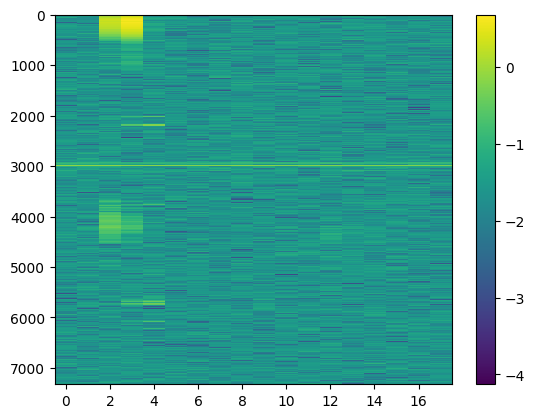

In [ ]:
plt.imshow(np.log10(np.abs(visibility_phased)), aspect='auto',interpolation="none")
plt.colorbar()

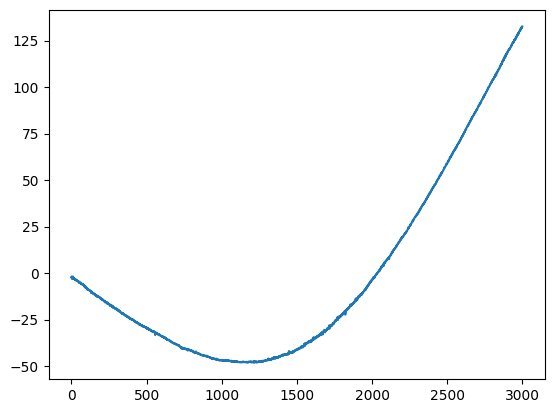

In [ ]:
plt.plot(np.unwrap(vis_phase[1000:4000,74]))

In [ ]:
d = outils.get_sat_delay(
                    a1_coords,
                    a2_coords,
                    tle_path,
                    t_start,
                    int(t_end-t_start)+1,
                    28654,
                )

catalog #28654 epoch 2024-07-24 20:56:55 UTC


In [ ]:
delay = np.interp(
    np.arange(0, nchunks) * acclen * T_SPECTRA, np.arange(0, int(t_end-t_start)+1), d
)

In [ ]:
delay.shape

(10864,)

In [ ]:
channels[74]

1836

In [ ]:
#THIS WAS NOAA 18

pred=(-delay[1000:4000]+delay[1000])*2*np.pi*outils.chan2freq(channels[74],alias=True)
obs=np.unwrap(vis_phase[1000:4000,74])-vis_phase[1000,74]

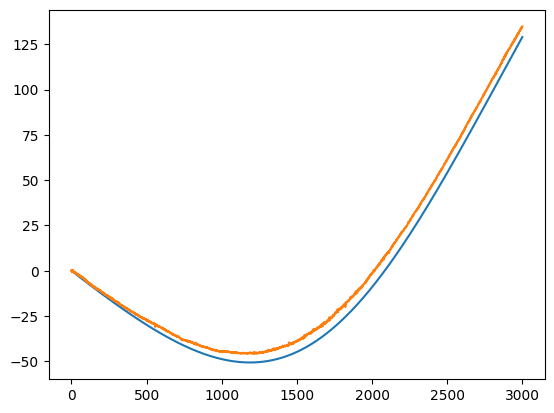

In [ ]:
plt.plot(pred)
plt.plot(obs)

catalog #59051 epoch 2024-07-24 21:55:34 UTC


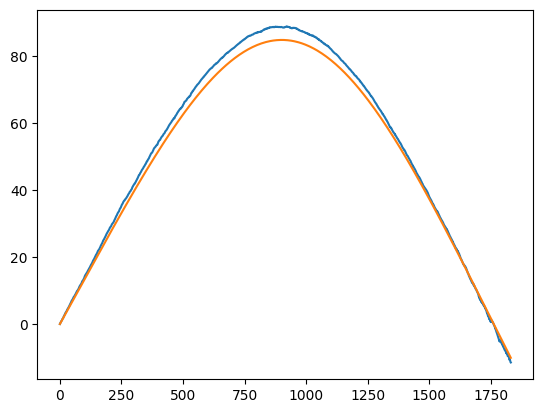

In [ ]:
#THIS WAS METEOR2-4
d = outils.get_sat_delay(
                    a1_coords,
                    a2_coords,
                    tle_path,
                    t_start,
                    int(t_end-t_start)+1,
                    59051,
                )
delay = np.interp(
    np.arange(0, nchunks) * acclen * T_SPECTRA, np.arange(0, int(t_end-t_start)+1), d
)
# pred=(-delay[1000:4000]+delay[1000])*2*np.pi*outils.chan2freq(channels[74],alias=True)
pred=(-delay[:]+delay[0])*2*np.pi*outils.chan2freq(1837,alias=True)
obs=np.unwrap(vis_phase[:,3])-vis_phase[0,3]
plt.plot(obs)
plt.plot(pred)

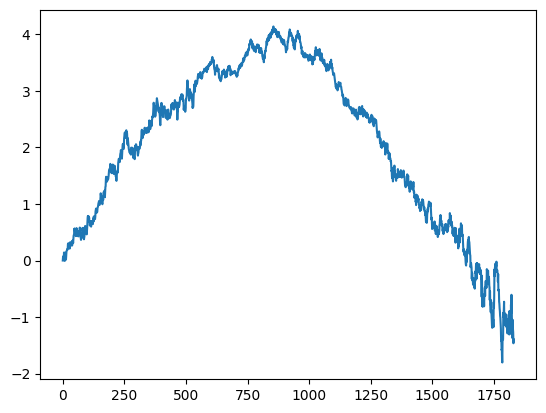

In [ ]:
plt.plot(obs-pred) # a lot of this is probably inaccurate positions.

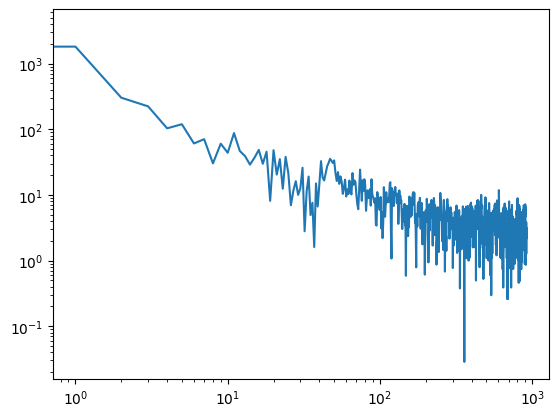

In [ ]:
plt.loglog(np.abs(np.fft.rfft(obs-pred)))

In [ ]:
outils.chan2freq(channels[74],alias=True)

137939453.125

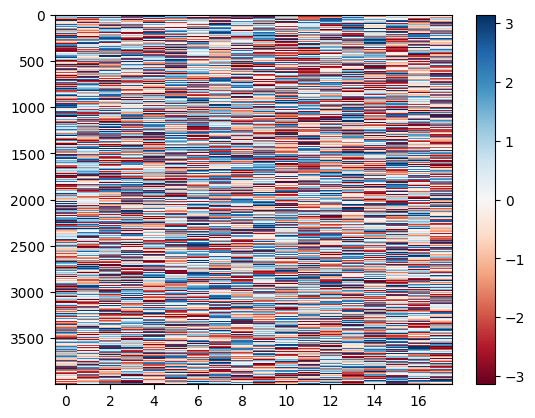

In [ ]:
vis_phase = np.angle(visibility_phased)
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:4000], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

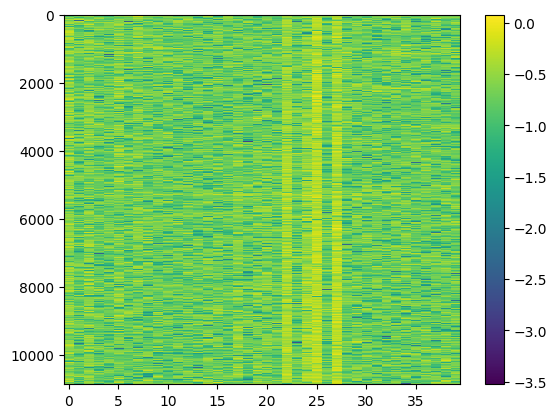

In [ ]:
plt.imshow(np.log10(np.abs(visibility_phased[:,:40])), aspect='auto',interpolation="none")
plt.colorbar()